# Camera Calibration


In [1]:
# # # UNIX-based system
# base_path = "d:\\VIBOT Master\\Semester 2\\Computer Vision\\Practicals\\Stereo\\stereo_reconstruction_cv"

# LINUX-based system
base_path = "/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv"
dataset_name = "dataset/d8"
calib_data_name = "calibration_data_logitech_1280x720"
# calib_data_name = "calibration_data_logitech_3840x2160"

lowe_ratio = 0.6  # for filtering feature matches

%cd $base_path

/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv


/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv/py3_10_cv4_11/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import open3d as o3d

class StereoCalibration(object):
    def __init__(self, filepath):
        # termination criteria
        self.criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            100,
            1e-5,
        )

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((9 * 7, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0:9, 0:7].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = []  # 3d point in real world space
        self.imgpoints_l = []  # 2d points in image plane.
        self.imgpoints_r = []  # 2d points in image plane.

        self.cal_path = filepath
        self.read_images(self.cal_path)

    def read_images(self, cal_path):
        checkerboardsize = (9, 7)
        images = glob.glob(cal_path + "/*.jpg")
        images_right = sorted([os.path.join(cal_path, img_path) for img_path in images])
        images_left = sorted([os.path.join(cal_path, img_path) for img_path in images])

        for i, fname in enumerate(images_right):

            img_l = cv2.imread(images_left[i])
            img_r = cv2.imread(images_right[i])

            gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret_l, corners_l = cv2.findChessboardCorners(
                gray_l,
                checkerboardsize,
                cv2.CALIB_CB_ADAPTIVE_THRESH
                + cv2.CALIB_CB_FAST_CHECK
                + cv2.CALIB_CB_NORMALIZE_IMAGE,
            )
            ret_r, corners_r = cv2.findChessboardCorners(
                gray_r,
                checkerboardsize,
                cv2.CALIB_CB_ADAPTIVE_THRESH
                + cv2.CALIB_CB_FAST_CHECK
                + cv2.CALIB_CB_NORMALIZE_IMAGE,
            )

            # If found, add object points, image points (after refining them)
            # self.objpoints.append(self.objp)

            if ret_l and ret_r:
                rt = cv2.cornerSubPix(
                    gray_l, corners_l, (11, 11), (-1, -1), self.criteria
                )
                self.imgpoints_l.append(corners_l)

                # Draw and display the corners
                ret_l = cv2.drawChessboardCorners(
                    img_l, checkerboardsize, corners_l, ret_l
                )
                rt = cv2.cornerSubPix(
                    gray_r, corners_r, (11, 11), (-1, -1), self.criteria
                )
                self.imgpoints_r.append(corners_r)

                # Draw and display the corners
                ret_r = cv2.drawChessboardCorners(
                    img_r, checkerboardsize, corners_r, ret_r
                )
                self.objpoints.append(self.objp)

        img_shape = gray_l.shape[::-1]

        rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_l, img_shape, None, None
        )
        rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_r, img_shape, None, None
        )

        self.camera_model = self.stereo_calibrate(img_shape)

    def stereo_calibrate(self, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        flags |= cv2.CALIB_ZERO_TANGENT_DIST

        stereocalib_criteria = (
            cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
            100,
            1e-5,
        )
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints,
            self.imgpoints_l,
            self.imgpoints_r,
            self.M1,
            self.d1,
            self.M2,
            self.d2,
            dims,
            criteria=stereocalib_criteria,
            flags=flags,
        )

        print("Intrinsic_mtx_1", M1)
        print("dist_1", d1)
        print("Intrinsic_mtx_2", M2)
        print("dist_2", d2)
        print("R", R)
        print("T", T)
        print("E", E)
        print("F", F)
        camera_model = dict(
            [
                ("M1", M1),
                ("M2", M2),
                ("dist1", d1),
                ("dist2", d2),
                ("rvecs1", self.r1),
                ("rvecs2", self.r2),
                ("R", R),
                ("T", T),
                ("E", E),
                ("F", F),
                ("image_size", dims),
            ]
        )

        return camera_model

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
cal_data = StereoCalibration(os.path.join(base_path, calib_data_name))

Intrinsic_mtx_1 [[1.49491610e+03 0.00000000e+00 6.51338571e+02]
 [0.00000000e+00 1.48784232e+03 4.40753670e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_1 [[ 0.28743235 -0.2783191   0.03948179  0.00182591  0.64196279]]
Intrinsic_mtx_2 [[1.49491610e+03 0.00000000e+00 6.51338571e+02]
 [0.00000000e+00 1.48784232e+03 4.40753670e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_2 [[ 0.28743235 -0.2783191   0.03948179  0.00182591  0.64196279]]
R [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
T [[-2.22044605e-15]
 [-4.44089210e-16]
 [ 4.75603231e-27]]
E [[ 0.00000000e+00 -4.75603231e-27 -4.44089210e-16]
 [ 4.75603231e-27  0.00000000e+00  2.22044605e-15]
 [ 4.44089210e-16 -2.22044605e-15  0.00000000e+00]]
F [[ 0.00000000e+00 -2.13831198e-33 -2.97066310e-19]
 [ 2.13831198e-33  0.00000000e+00  1.49239339e-18]
 [ 2.97066310e-19 -1.49239339e-18  0.00000000e+00]]


In [ ]:
K0 = np.array(cal_data.camera_model["M1"])
K1 = np.array(cal_data.camera_model["M2"])
dist_coeffs0 = np.array(cal_data.camera_model["dist1"])
dist_coeffs1 = np.array(cal_data.camera_model["dist2"])
R = np.array(cal_data.camera_model["R"])
T = np.array(cal_data.camera_model["T"])
F = np.array(cal_data.camera_model["F"])
E = np.array(cal_data.camera_model["E"])
image_size = np.array(cal_data.camera_model["image_size"])

# Rectification


In [5]:
def stereo_rectify(K0_, dist_coeffs0_, K1_, dist_coeffs1_, R_, T_, image_size):
    """Performs stereo rectification.

    This function takes the camera intrinsic parameters (K0_, K1_), rotation (R_),
    translation (T_) between the two cameras, and the image size, and returns
    the rectification transformations (R1, R2, P1, P2) and the disparity-to-depth
    mapping matrix (Q).  It uses OpenCV's stereoRectify function.

    Args:
        K0_: Camera intrinsic matrix for the left camera (3x3 numpy array).
        K1_: Camera intrinsic matrix for the right camera (3x3 numpy array).
        R_: Rotation matrix between the two cameras (3x3 numpy array).
        T_: Translation vector between the two cameras (3x1 or 1x3 numpy array).
        image_size: Size of the image (tuple or list of (width, height)).

    Returns:
        R1: Rectification rotation matrix for the left camera (3x3 numpy array).
        R2: Rectification rotation matrix for the right camera (3x3 numpy array).
        P1: Projection matrix for the left camera after rectification (3x4 numpy array).
        P2: Projection matrix for the right camera after rectification (3x4 numpy array).
        Q: Disparity-to-depth mapping matrix (4x4 numpy array).
    """
    T_ = T_.astype(np.float64)  # Ensure T_ is float64 for cv2.stereoRectify

    R1, R2, _, _, Q, _, _ = cv2.stereoRectify(
        K0_, dist_coeffs0_, K1_, dist_coeffs1_, image_size, R_, T_, alpha=1
    )
    # Compute the projection matrices for the two cameras
    P1 = K0_ @ np.hstack(
        (np.eye(3), np.zeros((3, 1)))
    )  # Projection matrix for the first camera
    P2 = K1_ @ np.hstack((R_, T_))  # Projection matrix for the second camera
    return R1, R2, P1, P2, Q

In [6]:
# Perform stereo rectification
R1, R2, P1, P2, Q = stereo_rectify(K0, dist_coeffs0, K1, dist_coeffs1, R, T, image_size)
# Compute the projection matrices for the two cameras
P1 = K0 @ np.hstack(
    (np.eye(3), np.zeros((3, 1)))
)  # Projection matrix for the first camera
P2 = K0 @ np.hstack((R, T))  # Projection matrix for the second camera
# Print results for verification
print("R1:\n", R1)
print("R2:\n", R2)
print("P1:\n", P1)
print("P2:\n", P2)
print("Q:\n", Q)

R1:
 [[ 9.80580676e-01  1.96116135e-01 -2.10033177e-12]
 [-1.96116135e-01  9.80580676e-01  2.07973830e-13]
 [ 2.10033177e-12  2.07973830e-13  1.00000000e+00]]
R2:
 [[ 9.80580676e-01  1.96116135e-01 -2.10033177e-12]
 [-1.96116135e-01  9.80580676e-01  2.07973830e-13]
 [ 2.10033177e-12  2.07973830e-13  1.00000000e+00]]
P1:
 [[1.49491610e+03 0.00000000e+00 6.51338571e+02 0.00000000e+00]
 [0.00000000e+00 1.48784232e+03 4.40753670e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
P2:
 [[ 1.49491610e+03  0.00000000e+00  6.51338571e+02 -3.31938055e-12]
 [ 0.00000000e+00  1.48784232e+03  4.40753670e+02 -6.60734720e-13]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  4.75603231e-27]]
Q:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -6.69163170e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -4.48294220e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.10086894e+03]
 [ 0.00000000e+00  0.00000000e+00  4.41614277e+14 -0.00000000e+00]]


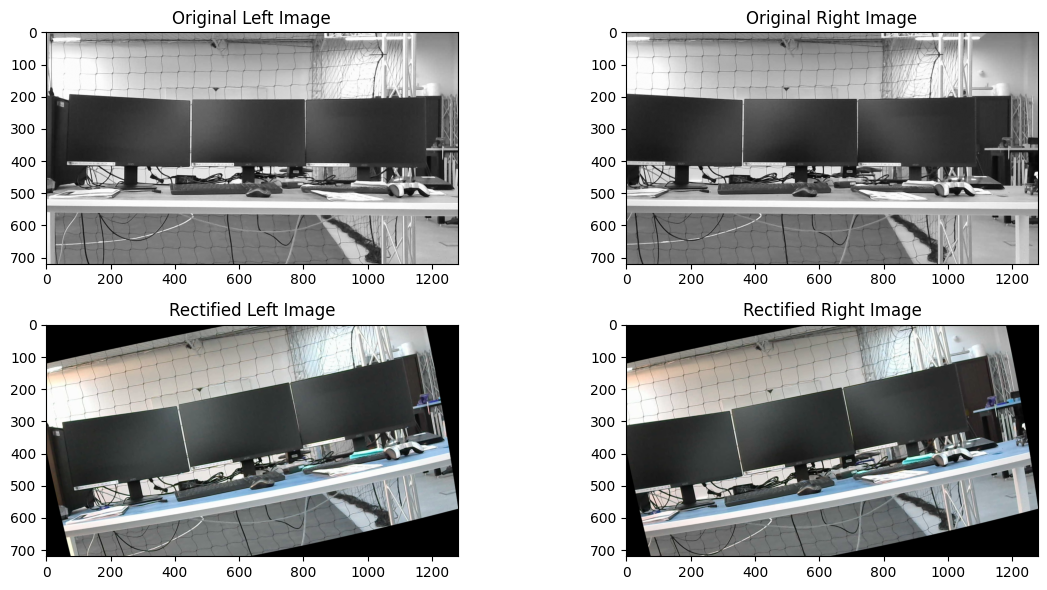

In [7]:
# Example usage (replace with your actual paths)
left_image = os.path.join(dataset_name, "img1.jpg")
right_image = os.path.join(dataset_name, "img2.jpg")

# Read Images
imgL = cv2.imread(left_image, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_image, cv2.IMREAD_GRAYSCALE)
imgL_color = cv2.imread(left_image)  # For color visualization
imgR_color = cv2.imread(right_image)  # For color visualization

# Rectify Images
mapL1, mapL2 = cv2.initUndistortRectifyMap(K0, dist_coeffs0, R1, P1, image_size, cv2.CV_16SC2)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K1, dist_coeffs1, R2, P2, image_size, cv2.CV_16SC2)

imgL_rect = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LANCZOS4)
imgR_rect = cv2.remap(imgR_color, mapR1, mapR2, interpolation=cv2.INTER_LANCZOS4)
imgL_rect_color = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LANCZOS4)


# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Original Left Image")
plt.imshow(imgL, cmap="gray")

plt.subplot(2, 2, 2)
plt.title("Original Right Image")
plt.imshow(imgR, cmap="gray")

plt.subplot(2, 2, 3)
plt.title("Rectified Left Image")
plt.imshow(imgL_rect, cmap="gray")

plt.subplot(2, 2, 4)
plt.title("Rectified Right Image")
plt.imshow(imgR_rect, cmap="gray")

plt.tight_layout()
plt.show()

Fundemental Matrix (F):
 [[-1.51921499e-08  2.44997274e-06 -1.82237334e-03]
 [ 3.00492347e-07 -1.91709019e-06  1.42587659e-01]
 [ 6.74402761e-04 -1.43660771e-01  1.00000000e+00]]
Relative Rotation (R):
 [[ 9.99922731e-01  1.50307768e-03 -1.23398590e-02]
 [-1.50389261e-03  9.99998868e-01 -5.67610612e-05]
 [ 1.23397597e-02  7.53144980e-05  9.99923859e-01]]
Relative Translation (T):
 [[-0.99941628]
 [-0.01760306]
 [-0.02927847]]


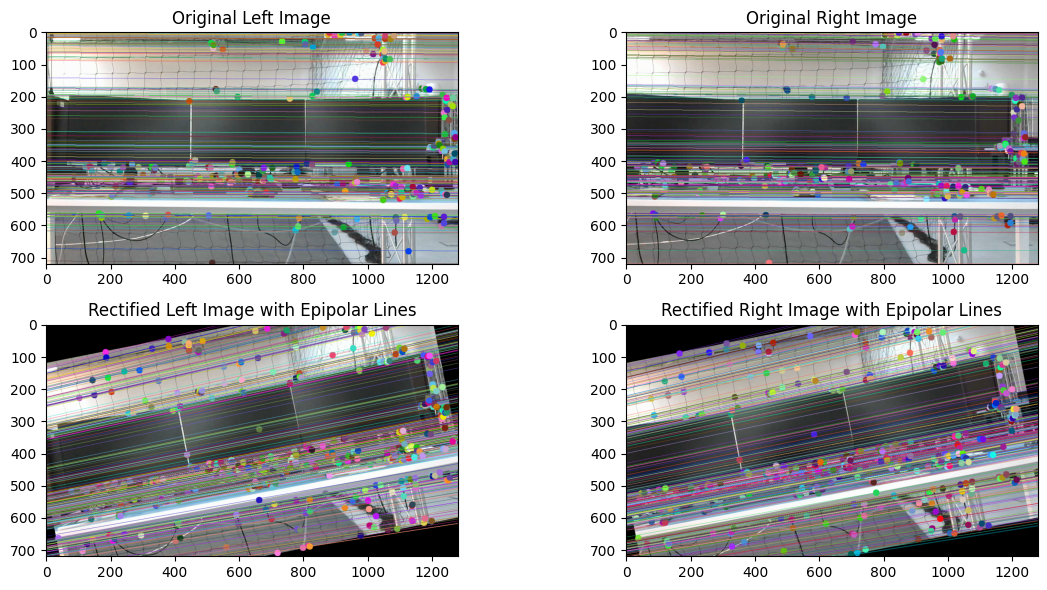

True

In [8]:
def draw_epilines(img1_, img2_, lines, pts1, pts2):
    """img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines"""
    img1 = img1_.copy()
    img2 = img2_.copy()
    r, c, _ = img1.shape
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 10, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 10, color, -1)
    return img1, img2


# Use SIFT for feature detection and matching
sift = cv2.SIFT_create()
keypoints_left, descriptors_left = sift.detectAndCompute(imgL_color, None)
keypoints_right, descriptors_right = sift.detectAndCompute(imgR_color, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Use FLANN-based matcher to find correspondences
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

# Filter matches using the Lowe's ratio test
pts_left = []
pts_right = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < lowe_ratio * n.distance:
        pts_left.append(keypoints_left[m.queryIdx].pt)
        pts_right.append(keypoints_right[m.trainIdx].pt)

pts_left = np.int32(pts_left)
pts_right = np.int32(pts_right)
F, mask = cv2.findFundamentalMat(pts_left, pts_right, cv2.FM_LMEDS)

# We select only inlier points
pts_left = pts_left[mask.ravel() == 1]
pts_right = pts_right[mask.ravel() == 1]

# Compute the Essential Matrix
E, mask = cv2.findEssentialMat(
    pts_left, pts_right, K0, method=cv2.RANSAC, prob=0.999, threshold=1.0
)

# Decompose the Essential Matrix to recover R and T
_, R, T, _ = cv2.recoverPose(E, pts_left, pts_right, K0)

print("Fundemental Matrix (F):\n", F)
print("Relative Rotation (R):\n", R)
print("Relative Translation (T):\n", T)

# Find epilines corresponding to points in right image and
# drawing its lines on left image
left_before_lines = cv2.computeCorrespondEpilines(pts_right.reshape(-1, 1, 2), 2, F)
left_before_lines = left_before_lines.reshape(-1, 3)
imgL_before_rec, _ = draw_epilines(
    imgL_color, imgR_color, left_before_lines, pts_left, pts_right
)

# Find epilines corresponding to points in left image and
# drawing its lines on right image
right_before_lines = cv2.computeCorrespondEpilines(pts_left.reshape(-1, 1, 2), 1, F)
right_before_lines = right_before_lines.reshape(-1, 3)
imgR_before_rec, _ = draw_epilines(
    imgR_color, imgL_color, right_before_lines, pts_right, pts_left
)

# Rectify Images
mapL1, mapL2 = cv2.initUndistortRectifyMap(K0, None, R1, P1, image_size, cv2.CV_32F)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K1, None, R2, P2, image_size, cv2.CV_32F)

imgL_rect = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)
imgR_rect = cv2.remap(imgR_color, mapR1, mapR2, interpolation=cv2.INTER_LINEAR)
imgL_rect_color = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)

## REDO everything now for the rectified pair
# Use SIFT for feature detection and matching
sift = cv2.SIFT_create()
keypoints_left_rect, descriptors_left_rect = sift.detectAndCompute(imgL_rect, None)
keypoints_right_rect, descriptors_right_rect = sift.detectAndCompute(imgR_rect, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Use FLANN-based matcher to find correspondences
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors_left_rect, descriptors_right_rect, k=2)

# Filter matches using the Lowe's ratio test
pts_left_rect = []
pts_right_rect = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        pts_left_rect.append(keypoints_left_rect[m.queryIdx].pt)
        pts_right_rect.append(keypoints_right_rect[m.trainIdx].pt)


pts_left_rect = np.int32(pts_left_rect)
pts_right_rect = np.int32(pts_right_rect)
F_rect, mask = cv2.findFundamentalMat(pts_left_rect, pts_right_rect, cv2.FM_LMEDS)

# We select only inlier points
pts_left_rect = pts_left_rect[mask.ravel() == 1]
pts_right_rect = pts_right_rect[mask.ravel() == 1]

# Draw epipolar lines on the rectified images

# Find epilines corresponding to points in right image and
# drawing its lines on left image
left_after_lines = cv2.computeCorrespondEpilines(
    pts_right_rect.reshape(-1, 1, 2), 2, F_rect
)
left_after_lines = left_after_lines.reshape(-1, 3)
imgL_after_rec, _ = draw_epilines(
    imgL_rect, imgR_rect, left_after_lines, pts_left_rect, pts_right_rect
)

# Find epilines corresponding to points in left image and
# drawing its lines on right image
right_after_lines = cv2.computeCorrespondEpilines(
    pts_right_rect.reshape(-1, 1, 2), 1, F_rect
)
right_after_lines = right_after_lines.reshape(-1, 3)
imgR_after_rec, _ = draw_epilines(
    imgR_rect, imgL_rect, right_after_lines, pts_right_rect, pts_left_rect
)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Original Left Image")
plt.imshow(imgL_before_rec, cmap="gray")

plt.subplot(2, 2, 2)
plt.title("Original Right Image")
plt.imshow(imgR_before_rec, cmap="gray")

plt.subplot(2, 2, 3)
plt.title("Rectified Left Image with Epipolar Lines")
plt.imshow(imgL_after_rec, cmap="gray")

plt.subplot(2, 2, 4)
plt.title("Rectified Right Image with Epipolar Lines")
plt.imshow(imgR_after_rec, cmap="gray")

plt.tight_layout()
plt.show()

# Save the rectified images
cv2.imwrite(os.path.join(dataset_name, "left_rectified.jpg"), imgL_rect)
cv2.imwrite(os.path.join(dataset_name, "right_rectified.jpg"), imgR_rect)
cv2.imwrite("right_rectified_lines.jpg", imgR_after_rec)
cv2.imwrite("left_rectified_lines.jpg", imgL_after_rec)

In [9]:
im0 = imgL_rect # An RGB image from left camera. Other options to use...imgL_color and imgL_rect
im1 = imgR_rect # An RGB image from right camera. Other options to use...imgR_color and imgR_rect

In [10]:
# Feature Detection and Matching with SIFT
def feat_detect_match(imgL_color, imgR_color):
    sift = cv2.SIFT_create()

    imgL = imgL_color #cv2.cvtColor(imgL_color, cv2.COLOR_BGR2GRAY)
    imgR = imgR_color #cv2.cvtColor(imgR_color, cv2.COLOR_BGR2GRAY)

    if imgL is None or imgR is None:
        return "Error: Failed to load one or both images."

    keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)
    print(f"SIFT: {len(keypoints_left)} keypoints detected in left image.")
    print(f"SIFT: {len(keypoints_right)} keypoints detected in right image.")

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Use FLANN-based matcher to find correspondences
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < lowe_ratio * n.distance]
    print(
        f"FLANN Matcher: {len(matches)} matches found, {len(good_matches)} after ratio test."
    )

    imgL_with_kp = cv2.drawKeypoints(
        imgL.copy(), keypoints_left, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    imgR_with_kp = cv2.drawKeypoints(
        imgR.copy(), keypoints_right, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    img_matches = cv2.drawMatchesKnn(
        imgL.copy(),
        keypoints_left,
        imgR.copy(),
        keypoints_right,
        matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    img_good_matches = cv2.drawMatches(
        imgL.copy(),
        keypoints_left,
        imgR.copy(),
        keypoints_right,
        good_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    # extract points
    pts1 = []
    pts2 = []
    for i, (m) in enumerate(good_matches):
        pts2.append(keypoints_right[m.trainIdx].pt)
        pts1.append(keypoints_left[m.queryIdx].pt)
    pts1 = np.asarray(pts1)
    pts2 = np.asarray(pts2)

    return imgL_with_kp, imgR_with_kp, img_matches, img_good_matches, pts1, pts2, matches, good_matches

SIFT: 3420 keypoints detected in left image.
SIFT: 3430 keypoints detected in right image.
FLANN Matcher: 3420 matches found, 257 after ratio test.


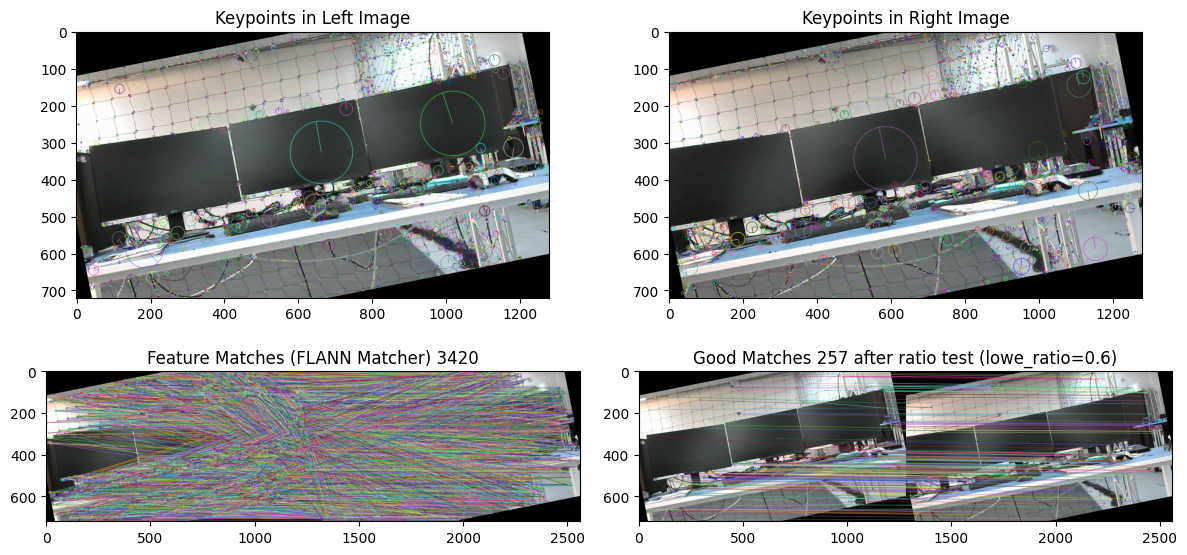

True

In [11]:
imgL_with_kp, imgR_with_kp, img_matches, img_good_matches, pts1, pts2, matches, good_matches= (
    feat_detect_match(im0, im1)
)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Keypoints in Left Image")
plt.imshow(imgL_with_kp)

plt.subplot(2, 2, 2)
plt.title("Keypoints in Right Image")
plt.imshow(imgR_with_kp)

plt.subplot(2, 2, 3)
plt.title(f"Feature Matches (FLANN Matcher) {len(matches)}")
plt.imshow(img_matches)

plt.subplot(2, 2, 4)
plt.title(f"Good Matches {len(good_matches)} after ratio test (lowe_ratio={lowe_ratio})")
plt.imshow(img_good_matches)

plt.tight_layout()
plt.show()
# Save the rectified images
cv2.imwrite(os.path.join(dataset_name, "imgL_with_kp.jpg"), imgL_with_kp)
cv2.imwrite(os.path.join(dataset_name, "imgR_with_kp.jpg"), imgR_with_kp)
cv2.imwrite(os.path.join(dataset_name, "img_matches.jpg"), img_matches)
cv2.imwrite(os.path.join(dataset_name, "img_good_matches.jpg"), img_good_matches)

## Triangulation (Sparse Reconstruction)

In [12]:
def visualize_sparse_point_cloud(points_3D):
    """
    Visualize the 3D point cloud using Open3D.

    Parameters:
    - points_3D: 3D points to visualize.
    """
    try:
        # Create a point cloud object
        pcd = o3d.geometry.PointCloud()

        # Set the points
        pcd.points = o3d.utility.Vector3dVector(
            points_3D.T
        )  # Transpose to match Open3D format

        # Optionally, set colors (here we set all points to red)
        colors = np.array([[1, 0, 0] for _ in range(points_3D.shape[1])])  # Red color
        pcd.colors = o3d.utility.Vector3dVector(colors)

        # Visualize the point cloud
        o3d.visualization.draw_geometries(
            [pcd], window_name="3D Point Cloud", width=800, height=600
        )
    except Exception as e:
        print(f"Error in visualize_point_cloud: {e}")


# Extract coordinates for triangulation
pts_left = pts1
pts_right = pts2

# Robustly estimate the fundamental matrix to filter out outliers with fine-tuned reprojection thresholds.
F, mask = cv2.findFundamentalMat(
    pts_left, pts_right, cv2.FM_RANSAC, ransacReprojThreshold=1.0
)
pts_left_filtered = pts_left[mask.ravel() == 1]
pts_right_filtered = pts_right[mask.ravel() == 1]

# Triangulate using projection matrices
pts_left_T = pts_left_filtered.T
pts_right_T = pts_right_filtered.T

# Compute the projection matrices for the two cameras
P1 = K0 @ np.hstack(
    (np.eye(3), np.zeros((3, 1)))
)  # Projection matrix for the first camera
P2 = K0 @ np.hstack((R, T))  # Projection matrix for the second camera

points_4d = cv2.triangulatePoints(P1, P2, pts_left_T, pts_right_T)
points_3d = points_4d[:3, :] / points_4d[3, :]
visualize_sparse_point_cloud(points_3d)


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Text(0.5, 1.0, 'Disparity Map (SGBM)')

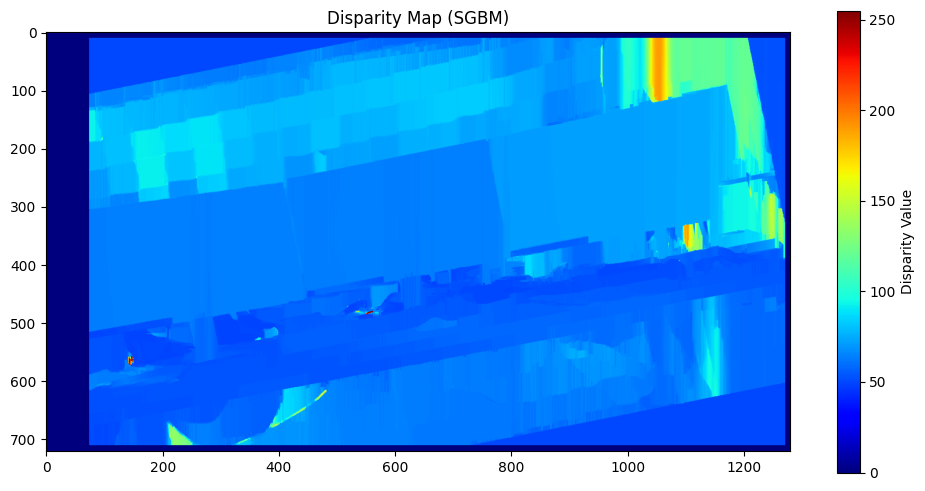

In [13]:
!pip3 install opencv-contrib-python
def compute_disparity_sgbm():
    """
    This function creates a StereoSGBM object with tuned parameters.
    StereoBM_create is a method from OpenCV library used for stereo correspondence matching.
    It is used to compute disparity between two rectified stereo images.

    Parameters:
    None

    Returns:
    stereo (cv2.StereoBM_create): A StereoSGBM object with tuned parameters.
    """
    # Create a StereoSGBM object with tuned parameters
    stereo = cv2.StereoBM_create()

    return stereo


stereo_left = compute_disparity_sgbm()  # Compute SGBM disparity map
stereo_right = cv2.ximgproc.createRightMatcher(stereo_left)  # Right matcher for WLS
imgL_rect_grey = cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY)
imgR_rect_grey = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)

# Compute disparity maps
disparity_left = stereo_left.compute(imgL_rect_grey, imgR_rect_grey).astype(np.float32) / 16.0
disparity_right = stereo_right.compute(imgR_rect_grey, imgL_rect_grey).astype(np.float32) / 16.0

# Create WLS filter
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo_left)
wls_filter.setLambda(1000000)# Higher values smooth more
wls_filter.setSigmaColor(3)  # Edge-preserving filter

# Apply WLS filtering
filtered_disparity = wls_filter.filter(
    disparity_left, imgL_rect_grey, disparity_map_right=disparity_right
)

# Normalize disparity for visualization
filtered_disparity_norm = cv2.normalize(
    filtered_disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
)
filtered_disparity_norm = np.int16(filtered_disparity_norm)

# Display the computed disparity maps
plt.figure(figsize=(12, 6))  # Set figure size
# Plot SGBM disparity map
plt.subplot(1, 1, 1)
plt.imshow(filtered_disparity_norm, cmap="jet")  # Use plasma colormap for visualization
plt.colorbar(label="Disparity Value")  # Add color legend
plt.title("Disparity Map (SGBM)")  # Title for SGBM disparity map

In [14]:
def reconstruct_3D(disparity_map, Q):
    """
    Reconstructs a 3D point cloud from the disparity map using the reprojection matrix.

    :param disparity_map: The computed disparity map (output from StereoSGBM or StereoBM)
    :param Q: The reprojection matrix obtained from stereo rectification
    :return: A 3D point cloud where each pixel (x, y) has a corresponding 3D coordinate (X, Y, Z)
    """
    # Convert disparity map into a 3D point cloud
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

    return points_3D


# Example usage (assuming Q is already computed from stereo rectification)
# Placeholder for reprojection matrix; replace with actual Q from stereo rectification

# Reconstruct 3D points using the SGBM disparity map
points_3D_sgbm = reconstruct_3D(filtered_disparity_norm, Q)
# Print the shape of the generated 3D point clouds for verification
print("3D Points (SGBM):", points_3D_sgbm.shape)  # Shape should match input image size

3D Points (SGBM): (720, 1280, 3)


In [15]:
import open3d as o3d


def visualize_point_cloud(points_3D, colors, disparity_map):
    """
    Visualizes the 3D point cloud using Open3D.

    :param points_3D: 3D reconstructed points (X, Y, Z) from disparity map
    :param colors: Corresponding RGB colors for each point
    :param disparity_map: Disparity map used for filtering valid points
    """
    # Mask invalid points (where disparity is NaN, infinite, or non-positive)
    mask = (
        ~np.isnan(points_3D[:, :, 0])
        & ~np.isinf(points_3D[:, :, 0])
        & (disparity_map > 0)
    )  # Added disparity threshold

    # Extract valid points and corresponding colors
    valid_points = points_3D[mask]
    valid_colors = colors[mask]

    # Create Open3D point cloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(
        valid_points.reshape(-1, 3)
    )  # Reshape into Nx3 format
    point_cloud.colors = o3d.utility.Vector3dVector(
        valid_colors.reshape(-1, 3) / 255.0
    )  # Normalize colors (0 to 1)

    # Visualize point cloud using Open3D
    o3d.visualization.draw_geometries([point_cloud])

# Load color image for point cloud visualization
colors = cv2.cvtColor(
    im0, cv2.COLOR_BGR2RGB
)  # Convert from BGR (OpenCV format) to RGB

# Visualize the reconstructed point cloud using SGBM disparity map
visualize_point_cloud(points_3D_sgbm, colors, filtered_disparity_norm)

## Triangulation (Sparse Reconstruction)


In [16]:
def visualize_sparse_point_cloud(points_3D):
    """
    Visualize the 3D point cloud using Open3D.

    Parameters:
    - points_3D: 3D points to visualize.
    """
    try:
        # Create a point cloud object
        pcd = o3d.geometry.PointCloud()

        # Set the points
        pcd.points = o3d.utility.Vector3dVector(
            points_3D.T
        )  # Transpose to match Open3D format

        # Optionally, set colors (here we set all points to red)
        colors = np.array([[1, 0, 0] for _ in range(points_3D.shape[1])])  # Red color
        pcd.colors = o3d.utility.Vector3dVector(colors)

        # Visualize the point cloud
        o3d.visualization.draw_geometries(
            [pcd], window_name="3D Point Cloud", width=800, height=600
        )
    except Exception as e:
        print(f"Error in visualize_point_cloud: {e}")


# Compute the projection matrices for the two cameras
P1 = K0 @ np.hstack(
    (np.eye(3), np.zeros((3, 1)))
)  # Projection matrix for the first camera
P2 = K0 @ np.hstack((R, T))  # Projection matrix for the second camera

# Perform triangulation to get 3D points
points_4d_hom = cv2.triangulatePoints(P1, P2, pts_left_T, pts_right_T)

# Convert from homogeneous coordinates to 3D
points_3d = points_4d_hom[:3] / points_4d_hom[3]

visualize_sparse_point_cloud(points_3d)

In [17]:
import open3d as o3d

# Load your point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d.T)  # Convert numpy to Open3D format

# Apply statistical outlier removal
pcd_filtered, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

# Visualize before and after
o3d.visualization.draw_geometries([pcd], window_name="Noisy Point Cloud")
o3d.visualization.draw_geometries([pcd_filtered], window_name="Filtered Point Cloud")
o3d.io.write_point_cloud(os.path.join(dataset_name, "point_cloud.ply"), pcd_filtered)

True

# Testing XFeat feature detector and matching for a POC

https://github.com/verlab/accelerated_features?tab=readme-ov-file


In [18]:
# !mkdir -p utils && cd utils && git clone 'https://github.com/verlab/accelerated_features.git'
%cd /home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv/utils/accelerated_features

/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv/utils/accelerated_features


/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv/py3_10_cv4_11/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [19]:
import numpy as np
import os
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt

from modules.xfeat import XFeat

xfeat = XFeat()

loading weights from: /home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv/utils/accelerated_features/modules/../weights/xfeat.pt


In [20]:
import cv2
import numpy as np


def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(
        ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999
    )
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array(
        [[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float32
    ).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i - 1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(
            img2_with_corners, start_point, end_point, (0, 255, 0), 4
        )  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i, i, 0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(
        img1,
        keypoints1,
        img2_with_corners,
        keypoints2,
        matches,
        None,
        matchColor=(0, 255, 0),
        flags=2,
    )

    return img_matches, keypoints1, keypoints2, matches

(4060, 2)
Num of Matches: (573,)


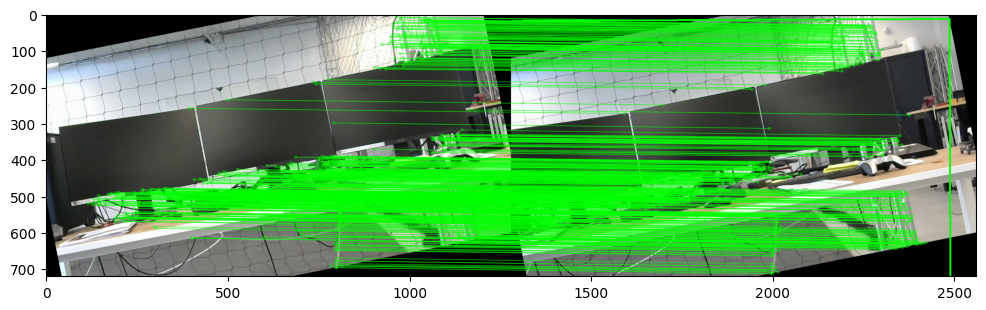

(<matplotlib.image.AxesImage at 0x7fe6ec899b10>, None)

In [21]:
# Use out-of-the-box function for extraction + MNN matching
mkpts_0, mkpts_1 = xfeat.match_xfeat(im0, im1, top_k=10000)
print(mkpts_0.shape)

canvas, keypoints1, keypoints2, matches = warp_corners_and_draw_matches(
    mkpts_0, mkpts_1, im0, im1
)
print(f"Num of Matches: {np.shape(matches)}")

plt.figure(figsize=(12, 12))
plt.imshow(canvas[..., ::-1]), plt.show()

(4097, 2)
Num of Matches: (693,)


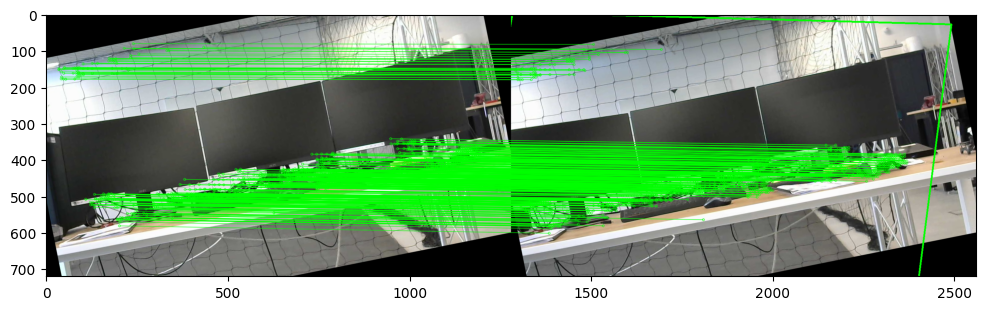

(<matplotlib.image.AxesImage at 0x7fe6ec823550>, None)

In [22]:
# Use out-of-the-box function for extraction + coarse-to-fine matching
mkpts_0, mkpts_1 = xfeat.match_xfeat_star(im0, im1, top_k=0)
print(mkpts_0.shape)
canvas, keypoints1, keypoints2, matches = warp_corners_and_draw_matches(
    mkpts_0, mkpts_1, im0, im1
)
print(f"Num of Matches: {np.shape(matches)}")
plt.figure(figsize=(12, 12))
plt.imshow(canvas[..., ::-1]), plt.show()

In [23]:
pts1 = np.float32([kp.pt for kp in keypoints1])
pts2 = np.float32([kp.pt for kp in keypoints2])

In [24]:
# Convert points to homogeneous coordinates
points1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3)
points2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3)

# Compute the projection matrices for the two cameras
P1 = K0 @ np.hstack(
    (np.eye(3), np.zeros((3, 1)))
)  # Projection matrix for the first camera
P2 = K0 @ np.hstack((R, T))  # Projection matrix for the second camera

print(points2_h)
# Perform triangulation to get 3D points

points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

# Convert from homogeneous coordinates to 3D
points_3d = points_4d_hom[:3] / points_4d_hom[3]

[[1.2000000e+03 4.7076923e+02 1.0000000e+00]
 [4.9333331e+02 4.7076923e+02 1.0000000e+00]
 [4.9333331e+02 4.8461536e+02 1.0000000e+00]
 ...
 [8.3076923e+02 2.4206898e+02 1.0000000e+00]
 [9.2307697e+02 2.6689658e+02 1.0000000e+00]
 [4.2461539e+02 2.7931036e+02 1.0000000e+00]]


In [26]:
# Load your point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d.T)  # Convert numpy to Open3D format

# Visualize before and after
o3d.visualization.draw_geometries([pcd], window_name="XFeat Point Cloud")